In [1]:
!pip install pandas networkx matplotlib torch torch_geometric scikit-learn seaborn umap-learn tensorboard optuna

In [122]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import torch
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.manifold import TSNE # Per la visualizzazione
import seaborn as sns # Per plot più belli
from sklearn.metrics.pairwise import cosine_similarity # Per la similarità KNN-like
from torch_geometric.transforms import RandomLinkSplit
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score 
import os

pd.set_option('display.max_colwidth', None)  # Mostra tutta la larghezza del contenuto della colonna
pd.set_option('display.max_columns', None)

# Verifica se CUDA è disponibile e imposta il device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Caricamento dataset

ratings

In [7]:
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


generi film

In [8]:
genres = pd.read_csv('./ml-100k/u.genre', sep='|', names=['genre', 'genre_id'], encoding='latin-1')
genres.head()

,genre,genre_id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


dataset film con colonne one-hot per i generi

In [9]:
movies_cols = ['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL'] + [f'genre_{row["genre"]}' for index, row in genres.iterrows()]
movies = pd.read_csv('./ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
movies.head()

,movieId,title,release_date,video_release_date,IMDb_URL,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [10]:
"Ratings", ratings.columns

('Ratings',
 Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object'))

In [11]:
"Movies", movies.columns

('Movies',
 Index(['movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
        'genre_unknown', 'genre_Action', 'genre_Adventure', 'genre_Animation',
        'genre_Children's', 'genre_Comedy', 'genre_Crime', 'genre_Documentary',
        'genre_Drama', 'genre_Fantasy', 'genre_Film-Noir', 'genre_Horror',
        'genre_Musical', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi',
        'genre_Thriller', 'genre_War', 'genre_Western'],
       dtype='object'))

# Preparazione vettori

In [127]:
def save_df(version, movies, users):
    os.makedirs(f'./datasets/{version}', exist_ok=True)

    movies.to_csv(f'./datasets/{version}/movies.csv', index=False, encoding='utf-8')
    users.to_csv(f'./datasets/{version}/users.csv', index=False, encoding='utf-8')

## vettori utente

per ogni utente creiamo le colonne generi che contano il numero di recensioni per quel genere

In [12]:
df_merged = pd.merge(ratings, movies, on='movieId', how='left')

# colonne generi
genre_cols = [f'genre_{row["genre"]}' for index, row in genres.iterrows()]

# 2. Melt the genre columns to have one row per user-movie-genre combination
df_genres_melted = df_merged.melt(id_vars=['userId', 'movieId'], value_vars=genre_cols,
                                  var_name='genre', value_name='is_genre')
df_genres_melted = df_genres_melted[df_genres_melted['is_genre'] == 1]

# 3. Group by userId and genre and count the occurrences
df_genre_counts = df_genres_melted.groupby(['userId', 'genre']).size().reset_index(name='review_count')

# 4. Pivot the table to get genres as columns
df_users = df_genre_counts.pivot_table(index='userId', columns='genre', values='review_count', fill_value=0)

# Reset index to make 'userId' a regular column and rename it
df_users = df_users.reset_index().rename(columns={'userId': 'user_id'})

# Display the resulting DataFrame
df_users.head()

genre,user_id,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,genre_unknown
0,1,75,42,12,25,91,25,5,107,2,1,13,13,5,44,43,52,25,6,1
1,2,10,3,1,4,16,9,0,35,1,2,2,1,4,16,4,12,3,0,0
2,3,14,4,0,0,12,10,1,22,0,2,5,2,11,5,8,21,5,0,0
3,4,8,4,0,0,4,4,1,6,0,0,1,1,5,3,6,11,2,0,0
4,5,56,33,14,29,82,9,0,27,2,1,28,12,3,19,33,19,14,2,1


normalizzazione colonne generi

In [13]:
# Calculate the sum of genre counts for each user
df_users['total_genre_reviews'] = df_users[genre_cols].sum(axis=1)

df_users_normalized = df_users[genre_cols].div(
    df_users['total_genre_reviews'], axis=0
)

# Re-add the user_id column
df_users_normalized['user_id'] = df_users['user_id']

# Reorder columns to have user_id first
df_users_normalized = df_users_normalized[['user_id'] + genre_cols]

# Display the resulting normalized DataFrame
print("Normalized df_users head:")
df_users_normalized.head()

Normalized df_users head:


genre,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,0.001704,0.127768,0.071550,0.020443,0.042589,0.155026,0.042589,0.008518,0.182283,0.003407,0.001704,0.022147,0.022147,0.008518,0.074957,0.073254,0.088586,0.042589,0.010221
1,2,0.000000,0.081301,0.024390,0.008130,0.032520,0.130081,0.073171,0.000000,0.284553,0.008130,0.016260,0.016260,0.008130,0.032520,0.130081,0.032520,0.097561,0.024390,0.000000
2,3,0.000000,0.114754,0.032787,0.000000,0.000000,0.098361,0.081967,0.008197,0.180328,0.000000,0.016393,0.040984,0.016393,0.090164,0.040984,0.065574,0.172131,0.040984,0.000000
3,4,0.000000,0.142857,0.071429,0.000000,0.000000,0.071429,0.071429,0.017857,0.107143,0.000000,0.000000,0.017857,0.017857,0.089286,0.053571,0.107143,0.196429,0.035714,0.000000
4,5,0.002604,0.145833,0.085938,0.036458,0.075521,0.213542,0.023438,0.000000,0.070312,0.005208,0.002604,0.072917,0.031250,0.007812,0.049479,0.085938,0.049479,0.036458,0.005208


aggiunta colonna che indica la mediana dei rating espressi dall'utente

In [14]:
user_medians = ratings.groupby('userId')['rating'].median().reset_index()
user_medians = user_medians.rename(columns={'userId': 'user_id', 'rating': 'median'})
df_users_normalized = df_users_normalized.merge(user_medians, on='user_id', how='left')

df_users_normalized.head()

,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,median
0,1,0.001704,0.127768,0.071550,0.020443,0.042589,0.155026,0.042589,0.008518,0.182283,0.003407,0.001704,0.022147,0.022147,0.008518,0.074957,0.073254,0.088586,0.042589,0.010221,4.0
1,2,0.000000,0.081301,0.024390,0.008130,0.032520,0.130081,0.073171,0.000000,0.284553,0.008130,0.016260,0.016260,0.008130,0.032520,0.130081,0.032520,0.097561,0.024390,0.000000,4.0
2,3,0.000000,0.114754,0.032787,0.000000,0.000000,0.098361,0.081967,0.008197,0.180328,0.000000,0.016393,0.040984,0.016393,0.090164,0.040984,0.065574,0.172131,0.040984,0.000000,3.0
3,4,0.000000,0.142857,0.071429,0.000000,0.000000,0.071429,0.071429,0.017857,0.107143,0.000000,0.000000,0.017857,0.017857,0.089286,0.053571,0.107143,0.196429,0.035714,0.000000,5.0
4,5,0.002604,0.145833,0.085938,0.036458,0.075521,0.213542,0.023438,0.000000,0.070312,0.005208,0.002604,0.072917,0.031250,0.007812,0.049479,0.085938,0.049479,0.036458,0.005208,3.0


In [119]:
stats = []

for col in genre_cols:
    media = df_users_normalized[col].mean()
    massimo = df_users_normalized[col].max()
    minimo = df_users_normalized[col].min()
    std = df_users_normalized[col].std()
    stats.append({
        'colonna': col,
        'media': media,
        'max': massimo,
        'min': minimo,
        'std': std
    })

df_stats = pd.DataFrame(stats)

# Calcolo media complessiva di media, max, min
total_row = {
    'colonna': 'total',
    'media': df_stats['media'].mean(),
    'max': df_stats['max'].mean(),
    'min': df_stats['min'].mean(),
    'std': df_stats['std'].mean()
}

# Aggiungiamo la riga al DataFrame
pd.concat([df_stats, pd.DataFrame([total_row])], ignore_index=True)

,colonna,media,max,min,std
0,genre_unknown,0.000041,0.019608,0.000000,0.000678
1,genre_Action,0.117094,0.349206,0.000000,0.047896
2,genre_Adventure,0.058277,0.206349,0.000000,0.031593
3,genre_Animation,0.014013,0.186047,0.000000,0.016095
4,genre_Children's,0.028909,0.302326,0.000000,0.026010
5,genre_Comedy,0.130530,0.463768,0.000000,0.057410
6,genre_Crime,0.040604,0.142857,0.000000,0.022395
7,genre_Documentary,0.003371,0.057971,0.000000,0.006421
8,genre_Drama,0.198023,0.561983,0.014286,0.077251
9,genre_Fantasy,0.004923,0.046512,0.000000,0.005920


## vettore film

rimozione colonne inutili

In [15]:
df_movies = movies[['movieId'] + genre_cols].rename(columns={'movieId': 'movie_id'})
df_movies.head()

,movie_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


aggiunta colonna mediana dei rating verso quel film

In [16]:
movie_medians = ratings.groupby('movieId')['rating'].median().reset_index()
movie_medians = movie_medians.rename(columns={'movieId': 'movie_id', 'rating': 'median'})

# 2. Unisci la mediana al DataFrame df_users
df_movies = df_movies.merge(movie_medians, on='movie_id', how='left')
df_movies.head()

,movie_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,median
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3.0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,4.0
4,5,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,3.0


In [125]:
save_df('0', df_movies, df_users_normalized)

## Treshold utenti

applicare dei pesi diversi in base a quanto un certo utente è fan di un determinato genere

In [131]:
import pandas as pd

stats = []

for col in genre_cols:
    media = df_users_normalized[col].mean()
    massimo = df_users_normalized[col].max()
    minimo = df_users_normalized[col].min()
    stats.append({
        'colonna': col,
        'media': media,
        'max': massimo,
        'min': minimo
    })

df_stats = pd.DataFrame(stats)

# Calcolo media complessiva di media, max, min
total_row = {
    'colonna': 'total',
    'media': df_stats['media'].mean(),
    'max': df_stats['max'].mean(),
    'min': df_stats['min'].mean()
}

# Aggiungiamo la riga al DataFrame
df_stats = pd.concat([df_stats, pd.DataFrame([total_row])], ignore_index=True)

df_stats

,colonna,media,max,min
0,genre_unknown,0.000041,0.019608,0.000000
1,genre_Action,0.117094,0.349206,0.000000
2,genre_Adventure,0.058277,0.206349,0.000000
3,genre_Animation,0.014013,0.186047,0.000000
4,genre_Children's,0.028909,0.302326,0.000000
5,genre_Comedy,0.130530,0.463768,0.000000
6,genre_Crime,0.040604,0.142857,0.000000
7,genre_Documentary,0.003371,0.057971,0.000000
8,genre_Drama,0.198023,0.561983,0.014286
9,genre_Fantasy,0.004923,0.046512,0.000000


In [139]:
df_users_normalized.columns

Index(['user_id', 'genre_unknown', 'genre_Action', 'genre_Adventure',
       'genre_Animation', 'genre_Children's', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Fantasy', 'genre_Film-Noir',
       'genre_Horror', 'genre_Musical', 'genre_Mystery', 'genre_Romance',
       'genre_Sci-Fi', 'genre_Thriller', 'genre_War', 'genre_Western',
       'median'],
      dtype='object')

In [145]:
import pandas as pd
import numpy as np

# Trova le colonne dei generi
genre_cols = [col for col in df_users_normalized.columns if col.startswith('genre_')]

# Calcola i percentili globali per ogni genere
percentiles = {}
for col in genre_cols:
    percentiles[col] = {
        'p25': np.percentile(df_users_normalized[col], 25),
        'p50': np.percentile(df_users_normalized[col], 50),
        'p75': np.percentile(df_users_normalized[col], 75),
    }

# Funzione per assegnare il peso basato sui percentili
def get_weight(value, p25, p50, p75):
    if value <= p25:
        return 0.5
    elif value <= p50:
        return 0.8
    elif value <= p75:
        return 1.0
    else:
        return 1.2

# Crea una copia per i pesi modificati
weighted_df = pd.DataFrame(index=df_users_normalized.index)

# Applica i pesi ai valori individuali
for col in genre_cols:
    p25 = percentiles[col]['p25']
    p50 = percentiles[col]['p50']
    p75 = percentiles[col]['p75']
    weighted_df[col] = df_users_normalized[col].apply(lambda x: x * get_weight(x, p25, p50, p75))

# Normalizza riga per riga per ottenere proporzioni
df_proportions = weighted_df.div(weighted_df.sum(axis=1), axis=0)

# Aggiungi user_id se necessario
df_users_weights = pd.concat([df_users_normalized[['user_id']], df_proportions], axis=1)

# Opzionale: stampa le prime righe
df_users_weights.head()

,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,0.002202,0.137640,0.077078,0.022022,0.055056,0.167003,0.045880,0.011011,0.157093,0.003670,0.001468,0.023858,0.023858,0.004588,0.064599,0.078914,0.076344,0.036704,0.011011
1,2,0.000000,0.040917,0.012275,0.006547,0.032733,0.130933,0.088380,0.000000,0.343699,0.008183,0.019640,0.013093,0.006547,0.032733,0.157119,0.016367,0.078560,0.012275,0.000000
2,3,0.000000,0.117351,0.016764,0.000000,0.000000,0.080469,0.100587,0.010059,0.147527,0.000000,0.020117,0.050293,0.013412,0.110645,0.020956,0.067058,0.211232,0.033529,0.000000
3,4,0.000000,0.147874,0.073937,0.000000,0.000000,0.036969,0.088725,0.022181,0.055453,0.000000,0.000000,0.014787,0.014787,0.110906,0.027726,0.133087,0.243993,0.029575,0.000000
4,5,0.002999,0.167958,0.098975,0.041990,0.086978,0.245939,0.011247,0.000000,0.033742,0.004999,0.002000,0.083979,0.035991,0.003749,0.023744,0.098975,0.023744,0.027993,0.004999


In [142]:
df_users_normalized.head()

,user_id,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,median
0,1,0.001704,0.127768,0.071550,0.020443,0.042589,0.155026,0.042589,0.008518,0.182283,0.003407,0.001704,0.022147,0.022147,0.008518,0.074957,0.073254,0.088586,0.042589,0.010221,4.0
1,2,0.000000,0.081301,0.024390,0.008130,0.032520,0.130081,0.073171,0.000000,0.284553,0.008130,0.016260,0.016260,0.008130,0.032520,0.130081,0.032520,0.097561,0.024390,0.000000,4.0
2,3,0.000000,0.114754,0.032787,0.000000,0.000000,0.098361,0.081967,0.008197,0.180328,0.000000,0.016393,0.040984,0.016393,0.090164,0.040984,0.065574,0.172131,0.040984,0.000000,3.0
3,4,0.000000,0.142857,0.071429,0.000000,0.000000,0.071429,0.071429,0.017857,0.107143,0.000000,0.000000,0.017857,0.017857,0.089286,0.053571,0.107143,0.196429,0.035714,0.000000,5.0
4,5,0.002604,0.145833,0.085938,0.036458,0.075521,0.213542,0.023438,0.000000,0.070312,0.005208,0.002604,0.072917,0.031250,0.007812,0.049479,0.085938,0.049479,0.036458,0.005208,3.0


In [146]:
save_df('1', movies, df_users_weights)

# Creazione grafo

In [17]:
B = nx.Graph()

nodi users

In [18]:
B.add_nodes_from(
    [
        (
            f"user_{uid}",
            {
                **{col: df_users_normalized.loc[df_users_normalized['user_id'] == uid, col].values[0] for col in df_users_normalized.columns if col != 'user_id'},
                'user_id': uid
            }
        )
        for uid in df_users_normalized['user_id']
    ],
    bipartite=0
)
print(f"Aggiunti {len(df_users_normalized)} nodi utente.")

Aggiunti 943 nodi utente.


In [19]:
print("Users node")
B.nodes['user_1']

Users node


{'bipartite': 0,
 'genre_unknown': 0.0017035775127768314,
 'genre_Action': 0.12776831345826234,
 'genre_Adventure': 0.07155025553662692,
 'genre_Animation': 0.020442930153321975,
 "genre_Children's": 0.04258943781942078,
 'genre_Comedy': 0.15502555366269166,
 'genre_Crime': 0.04258943781942078,
 'genre_Documentary': 0.008517887563884156,
 'genre_Drama': 0.18228279386712096,
 'genre_Fantasy': 0.0034071550255536627,
 'genre_Film-Noir': 0.0017035775127768314,
 'genre_Horror': 0.022146507666098807,
 'genre_Musical': 0.022146507666098807,
 'genre_Mystery': 0.008517887563884156,
 'genre_Romance': 0.07495741056218058,
 'genre_Sci-Fi': 0.07325383304940375,
 'genre_Thriller': 0.08858603066439523,
 'genre_War': 0.04258943781942078,
 'genre_Western': 0.010221465076660987,
 'median': 4.0,
 'user_id': 1}

nodi film

In [20]:
B.add_nodes_from(
    [
        (
            f"movie_{mid}",
            {
                'movie_id': mid,
                **{col: df_movies.loc[df_movies['movie_id'] == mid, col].values[0] for col in df_movies.columns if col != 'movie_id'}
            }
        )
        for mid in df_movies['movie_id']
    ],
    bipartite=1
)
print(f"Aggiunti {len(df_movies)} nodi film.")

Aggiunti 1682 nodi film.


In [21]:
print("Movies node")
B.nodes['movie_1']

Movies node


{'bipartite': 1,
 'movie_id': 1,
 'genre_unknown': 0,
 'genre_Action': 0,
 'genre_Adventure': 0,
 'genre_Animation': 1,
 "genre_Children's": 1,
 'genre_Comedy': 1,
 'genre_Crime': 0,
 'genre_Documentary': 0,
 'genre_Drama': 0,
 'genre_Fantasy': 0,
 'genre_Film-Noir': 0,
 'genre_Horror': 0,
 'genre_Musical': 0,
 'genre_Mystery': 0,
 'genre_Romance': 0,
 'genre_Sci-Fi': 0,
 'genre_Thriller': 0,
 'genre_War': 0,
 'genre_Western': 0,
 'median': 4.0}

In [22]:
for index, row in ratings.iterrows():
    user_node = f"user_{row['userId']}"
    movie_node = f"movie_{row['movieId']}"
    
    rating_value = row['rating']
    timestamp_value = row['timestamp']
    
    B.add_edge(user_node, movie_node, rating=rating_value, timestamp=timestamp_value)

print(f"\nGrafo Bipartito creato con successo!")
print(f"Numero totale di nodi nel grafo: {B.number_of_nodes()}")
print(f"Numero totale di archi nel grafo: {B.number_of_edges()}")


Grafo Bipartito creato con successo!
Numero totale di nodi nel grafo: 2625
Numero totale di archi nel grafo: 100000


Visualizzazione di un sottoinsieme: 5 utenti e 93 film correlati.


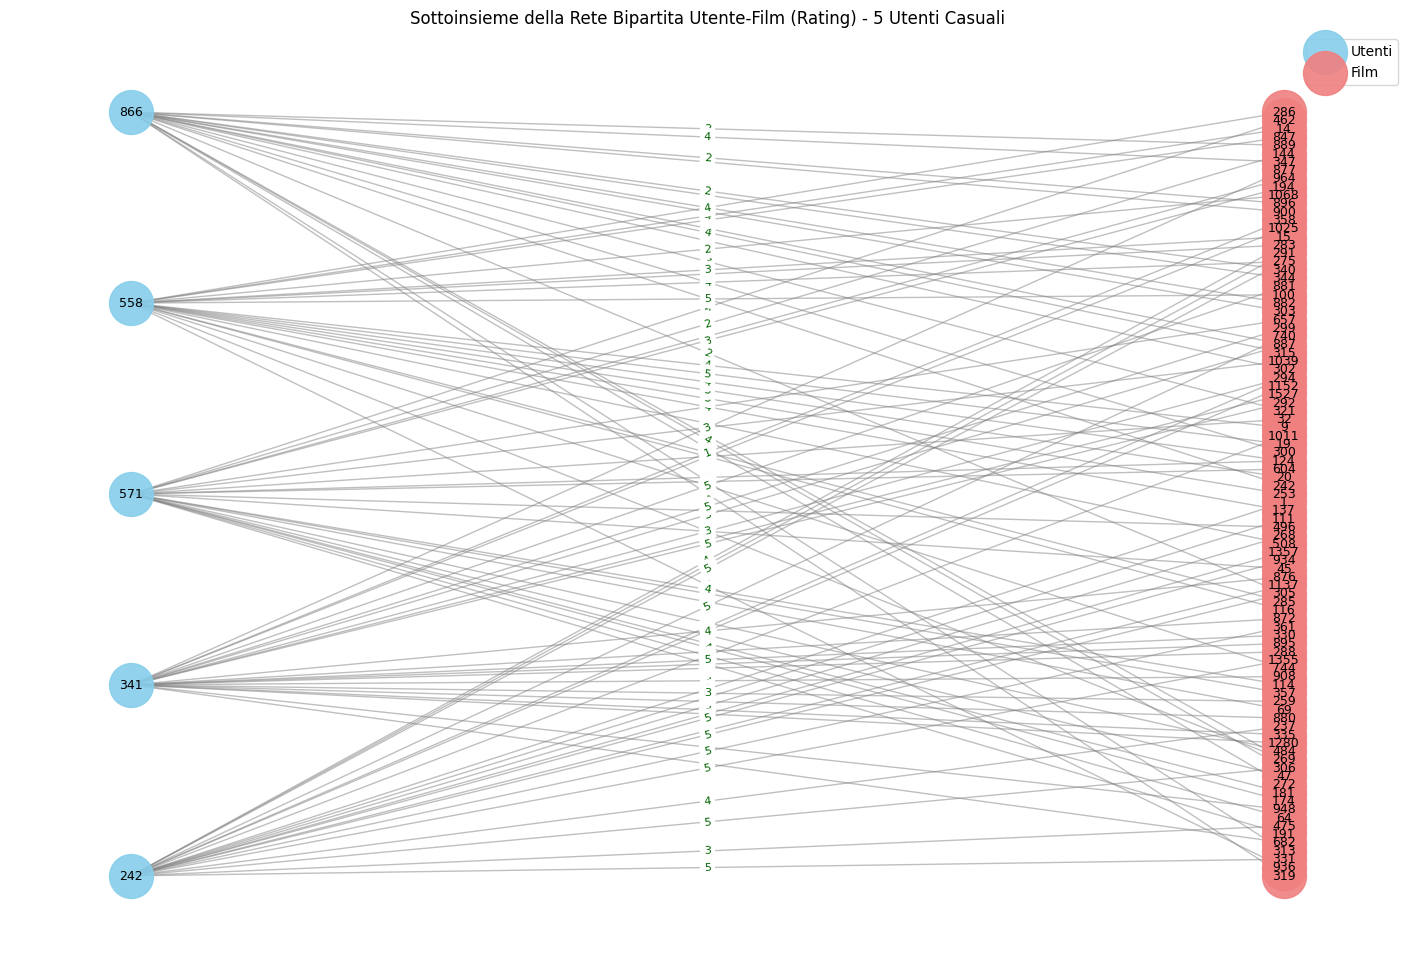

In [23]:
# Assicurati che il grafo 'B' sia già stato creato dal blocco precedente.

# Separa i nodi nei due set (utenti e film) usando l'attributo 'bipartite'
user_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
movie_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 1}

# --- PARAMETRI PER IL SOTTOINSIEME ---
# Puoi scegliere quanti utenti visualizzare.
users_count = 5
sorted_users = df_users.loc[df_users[genre_cols].sum(axis=1).nsmallest(users_count).index]
min_user_ids = sorted_users['user_id'].tolist()
selected_user_nodes = [f"user_{uid}" for uid in min_user_ids if f"user_{uid}" in user_nodes]

# Trova tutti i film collegati a questi utenti selezionati
selected_movie_nodes = set()
for u_node in selected_user_nodes:
    for neighbor in B.neighbors(u_node):
        selected_movie_nodes.add(neighbor)

# Crea un sotto-grafo con solo i nodi selezionati e i loro archi
# Subgraph restituirà un grafo con solo i nodi e gli archi tra essi.
subgraph_nodes = set(selected_user_nodes).union(selected_movie_nodes)
B_sub = B.subgraph(subgraph_nodes)

print(f"Visualizzazione di un sottoinsieme: {len(selected_user_nodes)} utenti e {len(selected_movie_nodes)} film correlati.")

plt.figure(figsize=(18, 12)) # Aumenta ancora la dimensione per una migliore leggibilità

# Utilizza il layout specifico per grafi bipartiti sul sotto-grafo.
# È importante passare i nodi del sotto-grafo che appartengono al set degli utenti.
# Filtrali dal set originale di user_nodes.
sub_user_nodes_for_layout = {n for n in selected_user_nodes if n in B_sub.nodes()}
pos_sub = nx.bipartite_layout(B_sub, sub_user_nodes_for_layout)

# --- Disegna i nodi del sotto-grafo ---
# Nodi Utente: colorati di azzurro
nx.draw_networkx_nodes(B_sub, pos_sub, nodelist=list(sub_user_nodes_for_layout), node_color='skyblue', node_size=1000, label='Utenti', alpha=0.9)
# Nodi Film: colorati di rosso corallo
nx.draw_networkx_nodes(B_sub, pos_sub, nodelist=list(selected_movie_nodes), node_color='lightcoral', node_size=1000, label='Film', alpha=0.9)

# --- Disegna gli archi del sotto-grafo ---
nx.draw_networkx_edges(B_sub, pos_sub, width=1.0, alpha=0.5, edge_color='gray')

# --- Aggiungi le etichette ai nodi del sotto-grafo ---
# Modifica qui per stampare l'ID utente nei nodi bipartite 0 e l'ID film nei nodi bipartite 1
labels = {}
for node, data in B_sub.nodes(data=True):
    if data['bipartite'] == 0:  # Nodo utente
        labels[node] = node.replace('user_', '') # Mostra solo l'ID numerico dell'utente
    elif data['bipartite'] == 1: # Nodo film
        labels[node] = data['movie_id']  # Mostra l'ID del film

nx.draw_networkx_labels(B_sub, pos_sub, labels, font_size=9, font_color='black')

# --- Aggiungi etichette per i rating sugli archi ---
edge_labels = nx.get_edge_attributes(B_sub, 'rating')
nx.draw_networkx_edge_labels(B_sub, pos_sub, edge_labels=edge_labels, font_size=8, font_color='darkgreen')

# --- Aggiungi una legenda ---
plt.title(f"Sottoinsieme della Rete Bipartita Utente-Film (Rating) - {users_count} Utenti Casuali")
plt.legend(scatterpoints=1)
plt.axis('off') # Nasconde gli assi del grafico
plt.show()

# GrapSAGE

conversione in pytorch geometric

In [24]:
# Mapping dei nodi
node_to_idx = {node: i for i, node in enumerate(B.nodes())}
idx_to_node = {i: node for node, i in node_to_idx.items()}
num_nodes = B.number_of_nodes()

user_keys = None
item_keys = None

for node in B.nodes():
    data = B.nodes[node]
    if data['bipartite'] == 0 and user_keys is None:
        user_keys = [k for k in data if k not in ('bipartite', 'user_id')]
    elif data['bipartite'] == 1 and item_keys is None:
        item_keys = [k for k in data if k not in ('bipartite', 'movie_id')]
    if user_keys and item_keys:
        break

# Costruisci le feature dinamicamente
features = []
for node in B.nodes():
    data = B.nodes[node]
    keys = user_keys if data['bipartite'] == 0 else item_keys
    feat = [float(data.get(k, 0.0)) for k in keys]  # fallback a 0.0 se mancante
    features.append(torch.tensor(feat, dtype=torch.float))


x = torch.stack(features)

edge_index_list = []
for u, v in B.edges():
    edge_index_list.append([node_to_idx[u], node_to_idx[v]])
    edge_index_list.append([node_to_idx[v], node_to_idx[u]])

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
edge_index = edge_index.to(device)


print(f"Numero totale di nodi: {num_nodes}")
print(f"Numero totale di archi (bidirezionali): {edge_index.size(1)}")

# Stampa info
user_count = sum(1 for node in B.nodes if B.nodes[node]['bipartite'] == 0)
item_count = num_nodes - user_count
print(f"Nodi utente: {user_count}, Nodi item (film): {item_count}")

# Stampa un solo nodo utente
user_node = next(node for node in B.nodes if B.nodes[node]['bipartite'] == 0)
user_idx = node_to_idx[user_node]
print("\nNodo utente:")
print(f" Nodo: {user_node}")
print(f" Feature: {x[user_idx].cpu().numpy()}")

# Stampa un solo nodo item (film)
item_node = next(node for node in B.nodes if B.nodes[node]['bipartite'] == 1)
item_idx = node_to_idx[item_node]
print("\nNodo film:")
print(f" Nodo: {item_node}")
print(f" Feature: {x[item_idx].cpu().numpy()}")

Numero totale di nodi: 2625
Numero totale di archi (bidirezionali): 200000
Nodi utente: 943, Nodi item (film): 1682

Nodo utente:
 Nodo: user_1
 Feature: [1.70357747e-03 1.27768308e-01 7.15502575e-02 2.04429310e-02
 4.25894372e-02 1.55025557e-01 4.25894372e-02 8.51788744e-03
 1.82282791e-01 3.40715493e-03 1.70357747e-03 2.21465081e-02
 2.21465081e-02 8.51788744e-03 7.49574080e-02 7.32538328e-02
 8.85860324e-02 4.25894372e-02 1.02214655e-02 4.00000000e+00]

Nodo film:
 Nodo: movie_1
 Feature: [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4.]


split dataset in train e test

In [112]:
# Assumiamo che B, x, edge_index, node_to_idx siano già stati creati
network = Data(x=x, edge_index=edge_index)

# Suddividiamo gli archi in 80% training, 10% validazione, 10% test
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=True,
    num_val=0.2,
    num_test=0.1,
    split_labels=True
)

train_data, val_data, test_data = transform(network)

print("Train Data:\n", train_data)
print("\nValidation Data:\n", val_data)
print("\nTest Data:\n", test_data)

Train Data:
 Data(x=[2625, 20], edge_index=[2, 140000], pos_edge_label=[70000], pos_edge_label_index=[2, 70000], neg_edge_label=[70000], neg_edge_label_index=[2, 70000])

Validation Data:
 Data(x=[2625, 20], edge_index=[2, 140000], pos_edge_label=[20000], pos_edge_label_index=[2, 20000], neg_edge_label=[20000], neg_edge_label_index=[2, 20000])

Test Data:
 Data(x=[2625, 20], edge_index=[2, 180000], pos_edge_label=[10000], pos_edge_label_index=[2, 10000], neg_edge_label=[10000], neg_edge_label_index=[2, 10000])


definizione network

In [26]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super().__init__()
        
        self.convs = torch.nn.ModuleList()
        
        # Primo layer
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        
        # Layer intermedi
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        
        # Ultimo layer
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            
            if i < len(self.convs) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)

        return x

# Training

In [27]:
def get_scores(scores, labels):
    auc = roc_auc_score(labels.detach().cpu().numpy(), scores.detach().cpu().numpy())
    ap = average_precision_score(labels.detach().cpu().numpy(), scores.detach().cpu().numpy())

    return {
        'accuracy': auc,
        'precision': ap
    }

def process(model, data, treshold=None):
    node_embeddings = model(data.x, data.edge_index)
    
    pos_edge_embedding = node_embeddings[data.pos_edge_label_index[0]] * node_embeddings[data.pos_edge_label_index[1]]
    neg_edge_embedding = node_embeddings[data.neg_edge_label_index[0]] * node_embeddings[data.neg_edge_label_index[1]]

    pos_scores = pos_edge_embedding.sum(dim=1)
    neg_scores = neg_edge_embedding.sum(dim=1)

    scores = torch.cat([pos_scores, neg_scores])
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))])

    loss = F.binary_cross_entropy_with_logits(scores, labels)

    return loss, scores, labels

def train(model, optimizer, treshold=None):
    model.train()
    optimizer.zero_grad()

    loss, scores, labels = process(model, train_data, treshold)

    loss.backward()

    found_gradients = False
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            if grad_norm > 1e-9: 
                found_gradients = True

    optimizer.step()

    return {
        'loss': loss.item(),
        'scores': get_scores(scores, labels)        
    }

@torch.no_grad() 
def test(model, treshold=None):
    model.eval() 
    
    loss, scores, labels = process(model, test_data, treshold)
    
    return {
        'loss': loss.item(),
        'scores': get_scores(scores, labels)        
    }

In [28]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner

# 1) Definisci l’objective che include il loop epoche
def objective(trial):
    # 1.a) suggerisci gli iperparametri da tunare
    hidden_channels = trial.suggest_int('hidden_channels', 16, 128, step=16)
    out_channels = trial.suggest_int('out_channels', 16, 128, step=16)
    num_layers      = trial.suggest_int('num_layers', 1, 5)
    dropout         = trial.suggest_float('dropout', 0.0, 0.8)
    # lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    lr = 0.001

    # 1.b) (ri)istanzia il modello con i parametri suggeriti
    model = GraphSAGE(
        in_channels=network.x.size(1),
        hidden_channels=hidden_channels,
        out_channels=out_channels,
        num_layers=num_layers,
        dropout=dropout
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    exp = '2'
    name = f'exp_{exp}-{num_layers}_layers-{hidden_channels}_inSize-{out_channels}_outSize-{dropout}_dropout-lr_{lr}'
    writer = SummaryWriter(f'runs/{name}')
    print(f""
      f"num_layers={num_layers}, "
      f"hidden_channels={hidden_channels}, "
      f"out_channels={out_channels}, "
      f"dropout={dropout:.2f}, "
      f"learning_rate={lr:.1e}")

    best_acc = 0.0
    epochs   = 500

    for epoch in range(1, epochs + 1):
        train_res = train(model, optimizer)
        val_res  = test(model)

        # report a Optuna per il pruning
        trial.report(val_res['scores']['accuracy'], epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        combined_score = 0.5 * val_res['scores']['accuracy'] + 0.5 * val_res['scores']['precision']
        best_acc = max(best_acc, combined_score)

        # log e stampa ogni 10 epoche (o la prima)
        if epoch == 1 or epoch % 10 == 0:
            writer.add_scalar('loss/train', train_res['loss'], epoch)
            writer.add_scalar('auc/train',  train_res['scores']['accuracy'], epoch)
            writer.add_scalar('ap/train',   train_res['scores']['precision'], epoch)
            writer.add_scalar('loss/test',  val_res['loss'], epoch)
            writer.add_scalar('auc/test',   val_res['scores']['accuracy'], epoch)
            writer.add_scalar('ap/test',    val_res['scores']['precision'], epoch)
            
    print(f"Epoch {epoch:03d} | "
            f"lr={lr:.1e} hid={hidden_channels} lay={num_layers} drop={dropout:.2f} | "
            f"Train Acc={train_res['scores']['accuracy']:.4f} "
            f"Test Acc={val_res['scores']['accuracy']:.4f}\n\n")

    torch.save(model.state_dict(), f'./weights/{name}.pth')

    return best_acc

/home/kevin/Documents/uni/3anno/2_semestre/BIG DATA/graph-based-recommendation-system/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(),
    pruner=SuccessiveHalvingPruner(min_resource=50)
)
study.optimize(objective, n_trials=50, timeout=3600)

print("Best accuracy:", study.best_value)
print("Best params:", study.best_params)

[I 2025-06-17 15:39:10,606] A new study created in memory with name: no-name-7f5eb762-fcc2-4ee0-8685-706f54873a8b


num_layers=2, hidden_channels=16, out_channels=80, dropout=0.36, learning_rate=1.0e-03


[I 2025-06-17 15:41:56,925] Trial 0 finished with value: 0.7409650652742767 and parameters: {'hidden_channels': 16, 'out_channels': 80, 'num_layers': 2, 'dropout': 0.3586283319432966}. Best is trial 0 with value: 0.7409650652742767.


Epoch 500 | lr=1.0e-03 hid=16 lay=2 drop=0.36 | Train Acc=0.7035 Test Acc=0.7624


num_layers=4, hidden_channels=80, out_channels=16, dropout=0.25, learning_rate=1.0e-03


[I 2025-06-17 15:45:18,864] Trial 1 finished with value: 0.8402469017890181 and parameters: {'hidden_channels': 80, 'out_channels': 16, 'num_layers': 4, 'dropout': 0.25117576022349314}. Best is trial 1 with value: 0.8402469017890181.


Epoch 500 | lr=1.0e-03 hid=80 lay=4 drop=0.25 | Train Acc=0.8204 Test Acc=0.8410


num_layers=3, hidden_channels=80, out_channels=80, dropout=0.09, learning_rate=1.0e-03


[I 2025-06-17 15:45:44,312] Trial 2 pruned. 


num_layers=5, hidden_channels=48, out_channels=16, dropout=0.04, learning_rate=1.0e-03


[I 2025-06-17 15:46:03,414] Trial 3 pruned. 


num_layers=4, hidden_channels=80, out_channels=16, dropout=0.17, learning_rate=1.0e-03


[I 2025-06-17 15:47:19,150] Trial 4 pruned. 


num_layers=1, hidden_channels=32, out_channels=112, dropout=0.55, learning_rate=1.0e-03


[I 2025-06-17 15:47:40,950] Trial 5 pruned. 


num_layers=1, hidden_channels=16, out_channels=96, dropout=0.58, learning_rate=1.0e-03


[I 2025-06-17 15:48:02,208] Trial 6 pruned. 


num_layers=3, hidden_channels=96, out_channels=128, dropout=0.70, learning_rate=1.0e-03


[I 2025-06-17 15:48:30,798] Trial 7 pruned. 


num_layers=3, hidden_channels=128, out_channels=32, dropout=0.60, learning_rate=1.0e-03


[I 2025-06-17 15:48:53,714] Trial 8 pruned. 


num_layers=3, hidden_channels=16, out_channels=32, dropout=0.77, learning_rate=1.0e-03


[I 2025-06-17 15:49:07,989] Trial 9 pruned. 


num_layers=5, hidden_channels=112, out_channels=48, dropout=0.29, learning_rate=1.0e-03


[I 2025-06-17 15:51:15,353] Trial 10 pruned. 


num_layers=2, hidden_channels=48, out_channels=64, dropout=0.36, learning_rate=1.0e-03


[I 2025-06-17 15:51:33,269] Trial 11 pruned. 


num_layers=4, hidden_channels=64, out_channels=80, dropout=0.24, learning_rate=1.0e-03


[I 2025-06-17 15:52:00,965] Trial 12 pruned. 


num_layers=2, hidden_channels=64, out_channels=64, dropout=0.44, learning_rate=1.0e-03


[I 2025-06-17 15:52:18,560] Trial 13 pruned. 


num_layers=2, hidden_channels=96, out_channels=96, dropout=0.44, learning_rate=1.0e-03


[I 2025-06-17 15:52:40,829] Trial 14 pruned. 


num_layers=4, hidden_channels=48, out_channels=48, dropout=0.16, learning_rate=1.0e-03


[I 2025-06-17 15:53:50,155] Trial 15 pruned. 


num_layers=4, hidden_channels=96, out_channels=96, dropout=0.33, learning_rate=1.0e-03


[I 2025-06-17 15:54:17,591] Trial 16 pruned. 


num_layers=2, hidden_channels=32, out_channels=48, dropout=0.23, learning_rate=1.0e-03


[I 2025-06-17 15:54:31,948] Trial 17 pruned. 


num_layers=5, hidden_channels=128, out_channels=128, dropout=0.48, learning_rate=1.0e-03


[I 2025-06-17 15:55:17,066] Trial 18 pruned. 


num_layers=1, hidden_channels=32, out_channels=64, dropout=0.38, learning_rate=1.0e-03


[I 2025-06-17 15:55:34,662] Trial 19 pruned. 


num_layers=4, hidden_channels=64, out_channels=32, dropout=0.26, learning_rate=1.0e-03


[I 2025-06-17 15:55:56,904] Trial 20 pruned. 


num_layers=4, hidden_channels=80, out_channels=16, dropout=0.15, learning_rate=1.0e-03


[I 2025-06-17 15:59:24,887] Trial 21 finished with value: 0.8484073081041408 and parameters: {'hidden_channels': 80, 'out_channels': 16, 'num_layers': 4, 'dropout': 0.1452414277396875}. Best is trial 21 with value: 0.8484073081041408.


Epoch 500 | lr=1.0e-03 hid=80 lay=4 drop=0.15 | Train Acc=0.8391 Test Acc=0.8437


num_layers=4, hidden_channels=80, out_channels=16, dropout=0.13, learning_rate=1.0e-03


[I 2025-06-17 16:00:50,356] Trial 22 pruned. 


num_layers=3, hidden_channels=112, out_channels=32, dropout=0.00, learning_rate=1.0e-03


[I 2025-06-17 16:01:14,199] Trial 23 pruned. 


num_layers=5, hidden_channels=80, out_channels=16, dropout=0.19, learning_rate=1.0e-03


[I 2025-06-17 16:02:39,182] Trial 24 pruned. 


num_layers=2, hidden_channels=96, out_channels=48, dropout=0.30, learning_rate=1.0e-03


[I 2025-06-17 16:02:51,693] Trial 25 pruned. 


num_layers=4, hidden_channels=64, out_channels=80, dropout=0.08, learning_rate=1.0e-03


[I 2025-06-17 16:04:16,858] Trial 26 pruned. 


num_layers=3, hidden_channels=112, out_channels=112, dropout=0.49, learning_rate=1.0e-03


[I 2025-06-17 16:04:41,802] Trial 27 pruned. 


num_layers=5, hidden_channels=48, out_channels=32, dropout=0.40, learning_rate=1.0e-03


[I 2025-06-17 16:04:58,219] Trial 28 pruned. 


num_layers=3, hidden_channels=80, out_channels=64, dropout=0.10, learning_rate=1.0e-03


[I 2025-06-17 16:05:18,865] Trial 29 pruned. 


num_layers=4, hidden_channels=64, out_channels=16, dropout=0.28, learning_rate=1.0e-03


[I 2025-06-17 16:05:35,431] Trial 30 pruned. 


num_layers=5, hidden_channels=80, out_channels=16, dropout=0.19, learning_rate=1.0e-03


[I 2025-06-17 16:07:05,662] Trial 31 pruned. 


num_layers=5, hidden_channels=80, out_channels=16, dropout=0.20, learning_rate=1.0e-03


[I 2025-06-17 16:08:32,152] Trial 32 pruned. 


num_layers=5, hidden_channels=96, out_channels=16, dropout=0.05, learning_rate=1.0e-03


[I 2025-06-17 16:12:27,560] Trial 33 finished with value: 0.850582318339677 and parameters: {'hidden_channels': 96, 'out_channels': 16, 'num_layers': 5, 'dropout': 0.05277434594308242}. Best is trial 33 with value: 0.850582318339677.


Epoch 500 | lr=1.0e-03 hid=96 lay=5 drop=0.05 | Train Acc=0.8484 Test Acc=0.8451


num_layers=5, hidden_channels=96, out_channels=32, dropout=0.06, learning_rate=1.0e-03


[I 2025-06-17 16:12:51,082] Trial 34 pruned. 


num_layers=4, hidden_channels=112, out_channels=16, dropout=0.12, learning_rate=1.0e-03


[I 2025-06-17 16:13:13,378] Trial 35 pruned. 


num_layers=1, hidden_channels=96, out_channels=80, dropout=0.00, learning_rate=1.0e-03


[I 2025-06-17 16:13:32,658] Trial 36 pruned. 


num_layers=4, hidden_channels=80, out_channels=32, dropout=0.05, learning_rate=1.0e-03


[I 2025-06-17 16:13:54,658] Trial 37 pruned. 


num_layers=3, hidden_channels=16, out_channels=16, dropout=0.16, learning_rate=1.0e-03


[I 2025-06-17 16:14:04,786] Trial 38 pruned. 


num_layers=5, hidden_channels=32, out_channels=112, dropout=0.65, learning_rate=1.0e-03


[I 2025-06-17 16:14:27,842] Trial 39 pruned. 


num_layers=2, hidden_channels=112, out_channels=48, dropout=0.33, learning_rate=1.0e-03


[I 2025-06-17 16:14:44,774] Trial 40 pruned. 


num_layers=5, hidden_channels=80, out_channels=16, dropout=0.14, learning_rate=1.0e-03


[I 2025-06-17 16:18:11,772] Trial 41 finished with value: 0.8365385668486596 and parameters: {'hidden_channels': 80, 'out_channels': 16, 'num_layers': 5, 'dropout': 0.14393435185181327}. Best is trial 33 with value: 0.850582318339677.


Epoch 500 | lr=1.0e-03 hid=80 lay=5 drop=0.14 | Train Acc=0.8384 Test Acc=0.8378


num_layers=5, hidden_channels=96, out_channels=16, dropout=0.13, learning_rate=1.0e-03


[I 2025-06-17 16:22:19,415] Trial 42 finished with value: 0.8466648163175964 and parameters: {'hidden_channels': 96, 'out_channels': 16, 'num_layers': 5, 'dropout': 0.13366917934302291}. Best is trial 33 with value: 0.850582318339677.


Epoch 500 | lr=1.0e-03 hid=96 lay=5 drop=0.13 | Train Acc=0.8290 Test Acc=0.8370


num_layers=5, hidden_channels=96, out_channels=16, dropout=0.13, learning_rate=1.0e-03


[I 2025-06-17 16:26:16,302] Trial 43 finished with value: 0.8525747333375109 and parameters: {'hidden_channels': 96, 'out_channels': 16, 'num_layers': 5, 'dropout': 0.12518981609542887}. Best is trial 43 with value: 0.8525747333375109.


Epoch 500 | lr=1.0e-03 hid=96 lay=5 drop=0.13 | Train Acc=0.8434 Test Acc=0.8541


num_layers=5, hidden_channels=96, out_channels=32, dropout=0.09, learning_rate=1.0e-03


[I 2025-06-17 16:26:44,958] Trial 44 pruned. 


num_layers=5, hidden_channels=96, out_channels=16, dropout=0.04, learning_rate=1.0e-03


[I 2025-06-17 16:30:41,986] Trial 45 finished with value: 0.8585144215924821 and parameters: {'hidden_channels': 96, 'out_channels': 16, 'num_layers': 5, 'dropout': 0.044319175825833904}. Best is trial 45 with value: 0.8585144215924821.


Epoch 500 | lr=1.0e-03 hid=96 lay=5 drop=0.04 | Train Acc=0.8720 Test Acc=0.8627


num_layers=5, hidden_channels=96, out_channels=16, dropout=0.04, learning_rate=1.0e-03


[I 2025-06-17 16:34:18,980] Trial 46 finished with value: 0.8521989117393451 and parameters: {'hidden_channels': 96, 'out_channels': 16, 'num_layers': 5, 'dropout': 0.03703581075794144}. Best is trial 45 with value: 0.8585144215924821.


Epoch 500 | lr=1.0e-03 hid=96 lay=5 drop=0.04 | Train Acc=0.8557 Test Acc=0.8550


num_layers=5, hidden_channels=112, out_channels=32, dropout=0.03, learning_rate=1.0e-03


[I 2025-06-17 16:38:48,948] Trial 47 finished with value: 0.8619856281207108 and parameters: {'hidden_channels': 112, 'out_channels': 32, 'num_layers': 5, 'dropout': 0.032752112360011194}. Best is trial 47 with value: 0.8619856281207108.


Epoch 500 | lr=1.0e-03 hid=112 lay=5 drop=0.03 | Train Acc=0.8634 Test Acc=0.8675


num_layers=5, hidden_channels=128, out_channels=32, dropout=0.04, learning_rate=1.0e-03


[I 2025-06-17 16:43:29,377] Trial 48 finished with value: 0.8658278279525224 and parameters: {'hidden_channels': 128, 'out_channels': 32, 'num_layers': 5, 'dropout': 0.038231541786975076}. Best is trial 48 with value: 0.8658278279525224.


Epoch 500 | lr=1.0e-03 hid=128 lay=5 drop=0.04 | Train Acc=0.8696 Test Acc=0.8701


Best accuracy: 0.8658278279525224
Best params: {'hidden_channels': 128, 'out_channels': 32, 'num_layers': 5, 'dropout': 0.038231541786975076}


In [36]:
best_params = study.best_params
best_params['lr'] = 0.001
best_params

{'hidden_channels': 128,
 'out_channels': 32,
 'num_layers': 5,
 'dropout': 0.038231541786975076,
 'lr': 0.001}

In [37]:
model = GraphSAGE(
    in_channels=network.x.size(1),
    hidden_channels=best_params['hidden_channels'],
    out_channels=best_params['out_channels'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout'],
)

weights = f"exp_1-{best_params['num_layers']}_layers-{best_params['hidden_channels']}_inSize-{best_params['out_channels']}_outSize-{best_params['dropout']}_dropout-lr_{best_params['lr']}.pth"
model.load_state_dict(torch.load(f'./weights/{weights}'))
model.eval()
print(f"Caricato i pesi {weights}")

Caricato i pesi exp_1-5_layers-128_inSize-32_outSize-0.038231541786975076_dropout-lr_0.001.pth


/tmp/ipykernel_16180/3445538080.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./weights/{weights}'))


# Valutazione

In [95]:
import re
import torch

def load_weights(path, hidden_channels, out_channels, num_layers, dropout=0.5):
    # Costruisci il modello
    model = GraphSAGE(
        in_channels=network.x.size(1),
        hidden_channels=hidden_channels,
        out_channels=out_channels,
        num_layers=num_layers,
        dropout=dropout,
    )

    # Carica i pesi
    model.load_state_dict(torch.load(path))

    # Restituisci modello + parametri estratti

    return model

In [96]:
model = load_weights('./weights/exp_0-3_layers-128_outSize.pth', 64, 128, 3)

/tmp/ipykernel_16180/710948264.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


In [97]:
with torch.no_grad():
    node_embeddings = model(network.x, network.edge_index)


def get_node_id_field(node_id):
    """
    Recupera il campo ID specifico (user_id o movie_id) per un nodo dal grafo NetworkX B.
    """
    node_attrs = B.nodes[node_id]
    if node_attrs['bipartite'] == 0: # È un utente
        return node_attrs.get('user_id', node_id)
    else: # È un film (o item)
        return node_attrs.get('movie_id', node_id)

In [98]:
# --- ESEMPIO 1: Raccomandare FILM a un UTENTE ---
print("===== ESEMPIO 1: Raccomandare FILM a un UTENTE =====")

start_user_original_id = next(node for node, attrs in B.nodes(data=True) if attrs['bipartite'] == 0)
start_user_idx = node_to_idx[start_user_original_id]
start_user_embedding = node_embeddings[start_user_idx]

# Stampa solo l'ID dell'utente di partenza
print(f"Utente di Partenza: '{get_node_id_field(start_user_original_id)}'")

# Trova tutti i film a cui l'utente è già collegato (ID originali)
already_watched_movies_ids = set(B.neighbors(start_user_original_id))

# Candidati per la raccomandazione: tutti i nodi di TIPO FILM che l'utente NON ha ancora visto
candidate_movie_original_ids = [
    node_id for node_id, attrs in B.nodes(data=True)
    if attrs['bipartite'] == 1 and node_id not in already_watched_movies_ids
]

# Converti gli ID originali dei film candidati nei loro indici PyTorch Geometric
candidate_movie_indices = [node_to_idx[oid] for oid in candidate_movie_original_ids]
candidate_movie_embeddings = node_embeddings[candidate_movie_indices]

# Calcola i punteggi di connessione tra l'utente e i film candidati
reco_scores = (start_user_embedding * candidate_movie_embeddings).sum(dim=1)

# Ordina i candidati e prendi i Top-K
top_k = 5
sorted_reco_scores, sorted_reco_indices = torch.sort(reco_scores, descending=True)

recommended_movie_indices = [candidate_movie_indices[i] for i in sorted_reco_indices[:top_k]]
recommended_con_scores = sorted_reco_scores[:top_k]

print(f"\nTop {top_k} raccomandazioni di FILM per l'utente '{get_node_id_field(start_user_original_id)}':")
for movie_idx, score in zip(recommended_movie_indices, recommended_con_scores):
    movie_original_id = idx_to_node[movie_idx] # Converti l'indice PyG in ID originale

    # Stampa solo l'ID del film raccomandato
    print(f"  Film ID: '{get_node_id_field(movie_original_id)}', Probabilità: {torch.sigmoid(score).item():.4f}")

===== ESEMPIO 1: Raccomandare FILM a un UTENTE =====
Utente di Partenza: '1'

Top 5 raccomandazioni di FILM per l'utente '1':
  Film ID: '1122', Probabilità: 0.9791
  Film ID: '418', Probabilità: 0.9056
  Film ID: '1604', Probabilità: 0.9050
  Film ID: '373', Probabilità: 0.8705
  Film ID: '636', Probabilità: 0.8663


In [42]:
display(df_users[df_users['user_id']==1])
display(movies[movies['movieId'].isin([385, 423, 405])])

genre,user_id,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,genre_unknown,total_genre_reviews
0,1,75,42,12,25,91,25,5,107,2,1,13,13,5,44,43,52,25,6,1,587


,movieId,title,release_date,video_release_date,IMDb_URL,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
384,385,True Lies (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?True%20Lies%20(1994),0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
404,405,Mission: Impossible (1996),22-May-1996,NaN,http://us.imdb.com/M/title-exact?Mission:%20Impossible%20(1996),0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
422,423,E.T. the Extra-Terrestrial (1982),01-Jan-1982,NaN,http://us.imdb.com/M/title-exact?E%2ET%2E%20the%20Extra-Terrestrial%20%281982%29,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0


In [49]:
node_embeddings[0]

tensor([-0.3630, -0.3668, -0.0941, -0.3549, -0.3783, -0.1754, -0.2786,  0.3021,
         0.3497, -0.2491, -0.4183,  0.4264, -0.3336, -0.5523, -0.3067, -0.0870,
        -0.1393,  0.4845, -0.4164,  0.3446, -0.0437, -0.3380,  0.2569, -0.2489,
        -0.1820, -0.3844, -0.2895, -0.3393,  0.3746,  0.0738,  0.0022, -0.3069])

In [ ]:
print("===== ESEMPIO 2: Raccomandare FILM SIMILI a un FILM dato =====")

# Seleziona un film di partenza (nodo bipartite=1)
start_movie_original_id = next(node for node, attrs in B.nodes(data=True) if attrs['bipartite'] == 1)
start_movie_idx = node_to_idx[start_movie_original_id]
start_movie_embedding = node_embeddings[start_movie_idx].unsqueeze(0)  # shape: [1, dim]

# Stampa solo l'ID del film di partenza
print(f"\nFilm di Partenza Selezionato (bipartite=1): '{get_node_id_field(start_movie_original_id)}'")

# Candidati per la raccomandazione: tutti i film eccetto quello di partenza
candidate_similar_movie_ids = [
    node_id for node_id, attrs in B.nodes(data=True)
    if attrs['bipartite'] == 1 and node_id != start_movie_original_id
]

if not candidate_similar_movie_ids:
    print(f"Non ci sono altri film nel grafo simili a '{get_node_id_field(start_movie_original_id)}'.")
else:
    # Ottieni indici e embedding dei candidati
    candidate_similar_movie_indices = [node_to_idx[oid] for oid in candidate_similar_movie_ids]
    candidate_similar_movie_embeddings = node_embeddings[candidate_similar_movie_indices]  # shape: [N, dim]

    # Calcola la similarità coseno
    similarities = F.cosine_similarity(start_movie_embedding, candidate_similar_movie_embeddings, dim=1)

    # Prendi i top 5 più simili (o meno, se i candidati sono < 5)
    top_k = min(5, similarities.size(0))
    top_k_indices = torch.topk(similarities, top_k).indices

    # Recupera gli ID originali
    top_k_similar_movie_ids = [candidate_similar_movie_ids[i] for i in top_k_indices.tolist()]

    # Stampa risultati
    print(f"\nTop {top_k} film più simili a '{get_node_id_field(start_movie_original_id)}':")
    for idx, movie_id in enumerate(top_k_similar_movie_ids, 1):
        print(f"{idx}. {get_node_id_field(movie_id)}")

===== ESEMPIO 2: Raccomandare FILM SIMILI a un FILM dato =====

Film di Partenza Selezionato (bipartite=1): '1'


TypeError: norm() got multiple values for argument 'p'

In [100]:
idss = top_k_indices.tolist()
idss.insert(0,1)
idss

[1, 60, 381, 231, 48, 447]

In [101]:
movies[movies['movieId'].isin(idss)]

,movieId,title,release_date,video_release_date,IMDb_URL,genre_unknown,genre_Action,genre_Adventure,genre_Animation,genre_Children's,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
47,48,Hoop Dreams (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Hoop%20Dreams%20(1994),0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
59,60,Three Colors: Blue (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Trzy%20kolory:%20Niebieski%20(1993),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
230,231,Batman Returns (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Batman%20Returns%20(1992),0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
380,381,Muriel's Wedding (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Muriel's%20Wedding%20(1994),0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
446,447,Carrie (1976),01-Jan-1976,NaN,http://us.imdb.com/M/title-exact?Carrie%20(1976),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


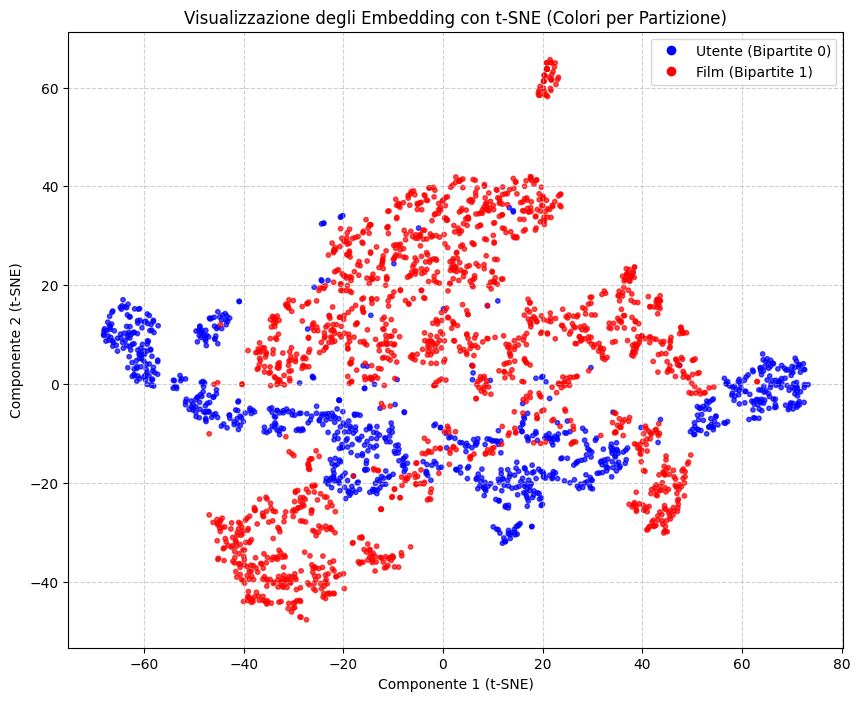

In [71]:
embeddings_np = node_embeddings.cpu().numpy()


tsne = TSNE(n_components=2, perplexity=30, random_state=42)


embeddings_2d_tsne = tsne.fit_transform(embeddings_np)

try:
    # Colori basati sulla partizione: 0 per Utente, 1 per Film
    colors = []
    for i in range(len(embeddings_np)):
        original_node_id = idx_to_node[i]
        node_type = B.nodes[original_node_id]['bipartite']
        colors.append('blue' if node_type == 0 else 'red') # Blu per Utenti, Rosso per Film

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1], 
                          c=colors, s=10, alpha=0.7)
    plt.title('Visualizzazione degli Embedding con t-SNE (Colori per Partizione)')
    plt.xlabel('Componente 1 (t-SNE)')
    plt.ylabel('Componente 2 (t-SNE)')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Crea una legenda manuale
    handles = [plt.Line2D([0], [0], marker='o', color='w', label='Utente (Bipartite 0)', 
                          markerfacecolor='blue', markersize=8),
               plt.Line2D([0], [0], marker='o', color='w', label='Film (Bipartite 1)', 
                          markerfacecolor='red', markersize=8)]
    plt.legend(handles=handles)
    plt.show()

except NameError:
    print("\nPer plottare con colori per partizione, assicurati che 'B' e 'idx_to_node' siano definiti.")
except Exception as e:
    print(f"\nErrore durante il plotting con colori per partizione (t-SNE): {e}")